# SOD314 Project

## Part I

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.kernel_ridge import KernelRidge
import numpy.random as rd

In [2]:
with open('first_database.pkl', 'rb') as f:
    x,y = pickle.load(f)

In [3]:
# Print the number of points in x and y
print("Number of points in x:", len(x))
print("Number of points in y:", len(y))

Number of points in x: 1000000
Number of points in y: 1000000


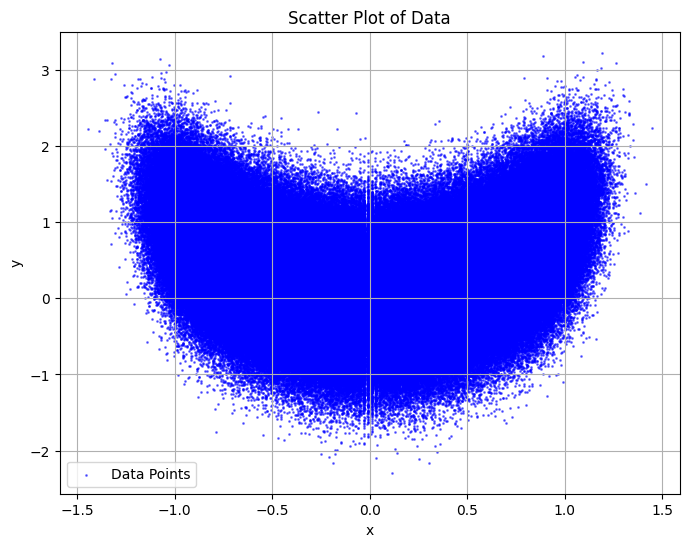

In [4]:
# Create a scatter plot to visualize the data
plt.figure(figsize=(8, 6))
plt.scatter(x, y, color='blue',s=1, alpha=0.5, label='Data Points')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Scatter Plot of Data')
plt.legend()
plt.grid(True)
plt.show()

## Decentralized gradient descent

In [5]:
n=100 # number of data points used for approximation
m=10 # approximation with m=sqrt(n)
a=5 #number of agents

In [25]:
x=x[:n] #select n first points of dataset
print("x :",x)
y=y[:n]
print("y :",y)
sel = [i for i in range(n)]
ind = np.random.choice(sel, m, replace=False)
x_selected = np.array([x[i] for i in ind])
print("x_selected :",x_selected)

x : [-1.         -0.97979798 -0.95959596 -0.93939394 -0.91919192 -0.8989899
 -0.87878788 -0.85858586 -0.83838384 -0.81818182 -0.7979798  -0.77777778
 -0.75757576 -0.73737374 -0.71717172 -0.6969697  -0.67676768 -0.65656566
 -0.63636364 -0.61616162 -0.5959596  -0.57575758 -0.55555556 -0.53535354
 -0.51515152 -0.49494949 -0.47474747 -0.45454545 -0.43434343 -0.41414141
 -0.39393939 -0.37373737 -0.35353535 -0.33333333 -0.31313131 -0.29292929
 -0.27272727 -0.25252525 -0.23232323 -0.21212121 -0.19191919 -0.17171717
 -0.15151515 -0.13131313 -0.11111111 -0.09090909 -0.07070707 -0.05050505
 -0.03030303 -0.01010101  0.01010101  0.03030303  0.05050505  0.07070707
  0.09090909  0.11111111  0.13131313  0.15151515  0.17171717  0.19191919
  0.21212121  0.23232323  0.25252525  0.27272727  0.29292929  0.31313131
  0.33333333  0.35353535  0.37373737  0.39393939  0.41414141  0.43434343
  0.45454545  0.47474747  0.49494949  0.51515152  0.53535354  0.55555556
  0.57575758  0.5959596   0.61616162  0.63636364

If all the data is available in one single location, we can solve for $\alpha^*$
via the optimality conditions, and
$$[\sigma^2K_{mm} + K_{nm}^\top K_{nm} + \nu I]\alpha^* = K_{nm}^\top y$$
Obviously, this can't be done with $n=10^6$ but with our value of $n=100$.

In [26]:
def euclidean_kernel(x, xi):
    return np.exp(np.linalg.norm(x - xi)**2)

def compute_kernel_matrix(X, Y):
    n = X.shape[0]
    m = Y.shape[0]
    K = np.zeros((n, m))
    for i in range(n):
        for j in range(m):
            K[i, j] = euclidean_kernel(X[i], Y[j])
    return K

def compute_alpha_star(Kmm, Knm, y, sigma_squared, nu):
    m = Kmm.shape[0]
    A = sigma_squared * Kmm + np.dot(Knm.T, Knm) + nu * np.eye(m)
    b = np.dot(Knm.T, y)
    alpha_star = np.linalg.solve(A, b)
    return alpha_star

In [36]:
# Define parameters
sigma = 0.5  # Example value
sigma_squared = 0.25
nu = 1.0  # Regularization parameter

In [37]:
"""
# Compute kernel matrices
Kmm = compute_kernel_matrix(x, x, k=0.5)
Knm = compute_kernel_matrix(x, x, k=0.5)

# Stack the target vector
y_stacked = y.reshape(-1, 1)

# Compute optimal alpha vector
alpha_star = compute_alpha_star(Kmm, Knm, y_stacked, sigma_squared, nu)

# Plot the result
x_pred = np.linspace(min(x), max(x), 1000).reshape(-1, 1)
K_pred = compute_kernel_matrix(x_pred, x, k=0.5)
y_pred = np.dot(K_pred, alpha_star)

plt.figure(figsize=(8, 6))
plt.scatter(x, y, color='blue', label='Data Points')
plt.plot(x_pred, y_pred, color='red', label='Kernel Ridge Regression')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Kernel Ridge Regression with Optimal Alpha')
plt.legend()
plt.grid(True)
plt.show()"""


"\n# Compute kernel matrices\nKmm = compute_kernel_matrix(x, x, k=0.5)\nKnm = compute_kernel_matrix(x, x, k=0.5)\n\n# Stack the target vector\ny_stacked = y.reshape(-1, 1)\n\n# Compute optimal alpha vector\nalpha_star = compute_alpha_star(Kmm, Knm, y_stacked, sigma_squared, nu)\n\n# Plot the result\nx_pred = np.linspace(min(x), max(x), 1000).reshape(-1, 1)\nK_pred = compute_kernel_matrix(x_pred, x, k=0.5)\ny_pred = np.dot(K_pred, alpha_star)\n\nplt.figure(figsize=(8, 6))\nplt.scatter(x, y, color='blue', label='Data Points')\nplt.plot(x_pred, y_pred, color='red', label='Kernel Ridge Regression')\nplt.xlabel('x')\nplt.ylabel('y')\nplt.title('Kernel Ridge Regression with Optimal Alpha')\nplt.legend()\nplt.grid(True)\nplt.show()"

If we consider all 1 million points, we cannot solve the problem exactly with the compute_alpha_star function. We will rather solve the minimization problem 
$$\alpha^* = \argmin_{\alpha \in \R^m}\frac{\sigma^2}{2}\alpha^\top K_{mm}\alpha +\frac{1}{2}
\|y − K_{nm}\alpha\|_2^2 +\frac{\nu}{2}\|\alpha\|_2^2,
$$
This optimisation problem can be solved by $a$ collaborating agents and formulated as the following distributed optimization problem:
$$\alpha^* = \argmin_{\alpha \in \R^m} \sum_{j=1}^a\left[ \frac{\sigma^2}{a}\frac{1}{2}\alpha^\top K_{mm}\alpha +\frac{1}{2}\sum_{i\in A(j)}
\|y_i − K_{(i)m}\alpha\|_2^2 +\frac{\nu}{2a}\|\alpha\|_2^2\right]
=\argmin_{\alpha \in \R^m}\sum_{j=1}^af_j(\alpha),
$$
where we indicated with $i \in A$ the data points that belong to agent $A(j)$, and with $K_{(i)m} =
[k(x_i, x_j )]_{j\in \mathcal{M}}$ of size $1\times m$.


Agent $j$'s gradient can be written as:
$$\R^m \ni \nabla_{\alpha}f_j(\alpha)=  \frac{\sigma}{a} K_{mm}\alpha +\sum_{i\in A(j)}K_{(i)m}^\top
( K_{(i)m}\alpha-y_i) +\frac{\nu}{a}\alpha \\
=
\frac{\sigma}{a} K_{mm}\alpha +K_{A(j)m}^\top
( K_{A(j)m}\alpha-y_{A(j)}) +\frac{\nu}{a}\alpha
$$
where we denoted $K_{A(j)m} =
[k(x_i, x_l)]_{i\in A(j),l\in \mathcal{M}}$ of size $|A(j)|\times m$. The number of data points of agent $j$, $|A(j)|$ equals in general $n/a$ (here = 100/5=20).

Here, we are not yet in the setup where each agent has its own copy of the target parameter $\alpha$.

In [61]:
def local_objective_function(alpha, sigma_squared, K_mm, y_local, K_im, nu, a):
    term1 = (sigma_squared / a) * (1 / 2) * np.dot(np.dot(alpha.T, K_mm), alpha)
    term2 = (1 / 2) * np.sum((y_local - K_im @ alpha)**2)
    term3 = (nu / (2 * a)) * np.linalg.norm(alpha)**2
    return term1 + term2 + term3

def compute_local_gradient(alpha, sigma_squared, K_mm, y_local, K_im, nu, a):
    grad = np.sqrt(sigma_squared) * K_mm @ alpha / a
    # print("K_im.T.shape:",K_im.T.shape)
    # print("(K_im @ alpha - y_local).shape:",(K_im @ alpha - y_local).shape)
    grad += K_im.T @ (K_im @ alpha - y_local)
    # print("grad.shape:",grad.shape)
    # print("alpha.shape:",alpha.shape)
    grad += (nu / a) * alpha
    return grad

## Decentralized Gradient Descent

Here is the pseudo-code for DGD:
- Start with $\alpha^i_0 \in \R^n$ at each device $i$
- Iterate: ask every device: $\alpha^i_{k+1} = \sum_{j=1}^a w_{ij}\alpha^j_k- s_k\nabla f_i(\alpha^i_k), \forall i \in \{1,\dots,a\}$

Here $w_{ij} = 0$ if device i and j are not connected, that is $\sum_{j=1}^a w_{ij}\alpha^j_k = w_{ii}\alpha^i_k + \sum_{j\in N_i} w_{ij}\alpha^j_k$ and the step size at iteration $k$ is $s_k$.

Practically, communication needs to happen synchronously and bi-directionally and we are giving a copy of $\alpha$ to each device and looking at the iterates $\alpha = [\alpha^1;\dots;\alpha^a]$ and
$$
\alpha_{k+1} = \textbf{W}\alpha_{k} -s_k \nabla_{\alpha} F(\alpha_k ), \quad F (\alpha) := \sum_{j=1}^af_j(\alpha^j),$$
where matrix $\textbf{W} = [W_{ij}]$ is the collection of the weights, it is assumed doubly stochastic and it is the mixing matrix. And $\textbf{W} = W \otimes I_n \in \R^{am\times am}$.

In [62]:
"""def create_graph(size, number_edge):
    if number_edge == 0:
        graph = np.eye(size)
        return graph
    else: 
        graph = create_graph(size, number_edge - 1)
        zeros_index = []
        for i in range(size):
            for j in range(i + 1, size):
                if graph[i,j] == 0:
                    zeros_index.append((i, j))
        ind = rd.randint(0, len(zeros_index) - 1)
        a,b = zeros_index[ind]
        graph[a,b] = 1
        graph[b,a] = 1
        return graph"""

We plot the optimality gap of agent $i$'s parameter at iteration $k$, which equals $\|\alpha^i_k - \alpha^*\|$, in a log-log plot.

In [89]:
def decentralized_gradient_descent(X, X_selected, y, sigma_squared, nu, a, num_iterations, step_size, alpha_star, W):
    m = X_selected.shape[0]
    n = X.shape[0]
    agents_data_indices = np.array_split(np.random.permutation(n), a)
    # each agent should have n/a=100/5=20 points
    print("agents_data_indices:",agents_data_indices)
    alpha = np.ones((m * a, 1))  # Initialize local variables for each agent
    all_optimality_gaps = [[] for _ in range(a)]  # Store optimality gaps for each agent
    
    # Create mixing matrix from communication matrix
    mixing_matrix = np.kron(W, np.eye(m))  # Mixing matrix
    
    # Compute kernel matrices
    K_mm = compute_kernel_matrix(X_selected, X_selected)
    Knm = compute_kernel_matrix(X, X_selected)
    
    for _ in range(num_iterations):
        # print("alpha ",alpha)
        all_gradients = np.zeros((m * a, 1))
        
        # Compute gradients for all agents
        for agent_idx, data_indices in enumerate(agents_data_indices):
            # Select data and compute local variables
            X_local = X[data_indices]
            y_local = y[data_indices].reshape(-1, 1)
            K_im = compute_kernel_matrix(X_local, X_selected)
            
            # Compute local gradient on local copy of alpha
            grad_local = compute_local_gradient(alpha[m * agent_idx: m * (agent_idx + 1)], sigma_squared, K_mm, y_local, K_im, nu, a)
            
            all_gradients[m * agent_idx: m * (agent_idx + 1)] = grad_local
        
        # print("all_gradients:",all_gradients)
        # Update alpha simultaneously for all agents
        alpha = mixing_matrix @ alpha - step_size * all_gradients
        
        # Compute and store optimality gaps for each agent
        for agent_idx in range(a):
            alpha_agent = alpha[m * agent_idx: m * (agent_idx + 1)].reshape(-1, 1)
            optimality_gap = np.linalg.norm(alpha_agent - alpha_star.reshape(-1, 1))
            all_optimality_gaps[agent_idx].append(optimality_gap)
        
    return all_optimality_gaps


In [94]:
import networkx as nx

def generate_line_graph(a):
    """
    Generate a line graph where each agent communicates only with its immediate neighbors.

    Parameters:
    a (int): Number of agents.

    Returns:
    np.ndarray: Adjacency matrix representing the line graph.
    """
    line_graph = np.zeros((a, a))
    for i in range(a - 1):
        line_graph[i, i + 1] = 1
        line_graph[i + 1, i] = 1
    return line_graph

def generate_small_world_graph(a, p=0.1):
    """
    Generate a small-world graph with a specified number of agents and probability of rewiring.

    Parameters:
    a (int): Number of agents.
    p (float): Probability of rewiring.

    Returns:
    np.ndarray: Adjacency matrix representing the small-world graph.
    """
    small_world_graph = nx.watts_strogatz_graph(a, 2, p)
    return nx.to_numpy_array(small_world_graph)

def generate_fully_connected_graph(a):
    """
    Generate a fully connected graph where each agent communicates with every other agent directly.

    Parameters:
    a (int): Number of agents.

    Returns:
    np.ndarray: Adjacency matrix representing the fully connected graph.
    """
    return (np.ones((a, a)) - np.eye(a))/a

def generate_cycle_graph(a):
    """
    Generate a cycle graph where each agent communicates with its two adjacent agents forming a cycle.

    Parameters:
    a (int): Number of agents.

    Returns:
    np.ndarray: Adjacency matrix representing the cycle graph.
    """
    cycle_graph = np.zeros((a, a))
    for i in range(a):
        cycle_graph[i, (i - 1) % a] = 1  # Left neighbor
        cycle_graph[i, (i + 1) % a] = 1  # Right neighbor
    return cycle_graph

def renormalize_graph(graph):
    """
    Renormalize the given graph to make it doubly stochastic.

    Parameters:
    graph (np.ndarray): Adjacency matrix representing the graph.

    Returns:
    np.ndarray: Doubly stochastic matrix obtained by renormalizing the input graph.
    """
    row_sums = np.sum(graph, axis=1)
    col_sums = np.sum(graph, axis=0)
    row_normalized = graph / row_sums[:, np.newaxis]
    col_normalized = row_normalized / col_sums
    return col_normalized

In [99]:
# Generate communication graphs
line_graph = generate_line_graph(a)
print("line_graph:",line_graph)
# normalized_line_graph=renormalize_graph(line_graph)
# print("normalized_line_graph:",normalized_line_graph)

small_world_graph = generate_small_world_graph(a, p=0.1)
print("small_world_graph:",small_world_graph)

fully_connected_graph = generate_fully_connected_graph(a)
normalized_fully_connected_graph = renormalize_graph(fully_connected_graph)
print("normalized_fully_connected_graph:",normalized_fully_connected_graph)

cycle_graph = generate_cycle_graph(a)
normalized_cycle_graph = renormalize_graph(cycle_graph)
print("normalized_cycle_graph:",normalized_cycle_graph)

line_graph: [[0. 1. 0. 0. 0.]
 [1. 0. 1. 0. 0.]
 [0. 1. 0. 1. 0.]
 [0. 0. 1. 0. 1.]
 [0. 0. 0. 1. 0.]]
small_world_graph: [[0. 1. 0. 0. 1.]
 [1. 0. 1. 1. 0.]
 [0. 1. 0. 1. 0.]
 [0. 1. 1. 0. 0.]
 [1. 0. 0. 0. 0.]]
normalized_fully_connected_graph: [[0.     0.3125 0.3125 0.3125 0.3125]
 [0.3125 0.     0.3125 0.3125 0.3125]
 [0.3125 0.3125 0.     0.3125 0.3125]
 [0.3125 0.3125 0.3125 0.     0.3125]
 [0.3125 0.3125 0.3125 0.3125 0.    ]]
normalized_cycle_graph: [[0.   0.25 0.   0.   0.25]
 [0.25 0.   0.25 0.   0.  ]
 [0.   0.25 0.   0.25 0.  ]
 [0.   0.   0.25 0.   0.25]
 [0.25 0.   0.   0.25 0.  ]]


In [96]:
# Call decentralized gradient descent with different communication graphs
optimality_gap_line = decentralized_gradient_descent(X, X_selected, y, sigma_squared, nu, a, num_iterations, step_size, alpha_star, line_graph)
optimality_gap_small_world = decentralized_gradient_descent(X, X_selected, y, sigma_squared, nu, a, num_iterations, step_size, alpha_star, small_world_graph)
optimality_gap_fully_connected = decentralized_gradient_descent(X, X_selected, y, sigma_squared, nu, a, num_iterations, step_size, alpha_star, fully_connected_graph)


NameError: name 'X' is not defined

In [ ]:
num_iterations = 10000
# ESSENTIAL: must be small enough
step_size = 0.0001

# Compute alpha_star
K_mm = compute_kernel_matrix(x_selected, x_selected)
Knm = compute_kernel_matrix(x, x_selected)
alpha_star = compute_alpha_star(K_mm, Knm, y, sigma_squared, nu)
print("alpha_star.shape:",alpha_star.shape)
print("alpha_star ",alpha_star)

alpha_star.shape: (10,)
alpha_star  [-0.1752501  -0.05197285  0.18834464 -0.02195099 -0.13827867 -0.07658024
  0.1549855   0.02271957  0.12797344 -0.13363703]


In [ ]:
# Run decentralized gradient descent
all_optimality_gaps = decentralized_gradient_descent(x, x_selected, y, sigma_squared, nu, a, num_iterations, step_size, alpha_star)

agents_data_indices: [array([88, 18,  7, 87, 20, 22, 17, 59,  0, 45, 44, 84, 54,  8, 64, 61, 53,
       15, 38, 77]), array([23, 11, 31, 95, 60, 28, 47, 70, 66, 78, 92, 81, 99, 37, 75,  2, 94,
       36, 49, 56]), array([ 5, 27,  9, 63, 19, 71, 32, 67, 65, 43, 39, 82, 80, 55, 62, 73, 98,
       40, 21, 72]), array([96, 13, 24, 10, 12, 69, 33, 16, 90, 14, 26, 57, 34, 68, 58, 50, 76,
       52, 83, 48]), array([41, 42, 91,  3, 86, 74, 93,  6, 46,  4, 30, 89, 25, 35, 97, 79,  1,
       85, 29, 51])]


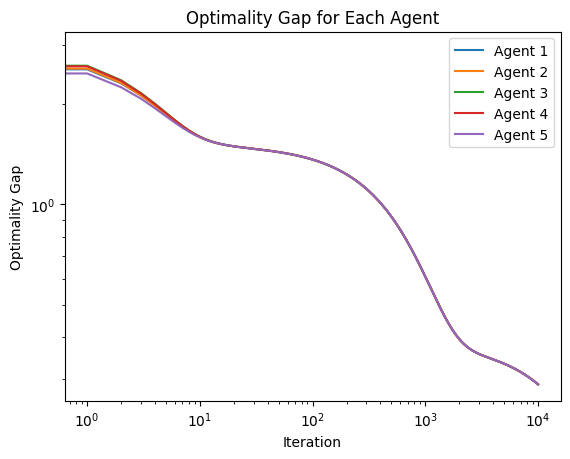

In [ ]:
# Plot optimality gaps for each agent
for agent_idx, optimality_gaps in enumerate(all_optimality_gaps):
    plt.plot(range(num_iterations), optimality_gaps, label=f"Agent {agent_idx + 1}")

plt.xlabel('Iteration')
plt.ylabel('Optimality Gap')
plt.title('Optimality Gap for Each Agent')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.show()

- We define the Adjacency matrix as $A \in {0, 1}^{|V|×|V|}$, with 1 entries if node i and j share an edge.
- The Laplacian matrix of a undirected graph $G$ is an $|V| × |V|$ symmetric matrix defined by
$L_G = D − A$,where $D =\textrm{diag}(d_1,\dots, d_n)$ is the degree matrix, which is the diagonal matrix formed from the vertex degrees.
- The vertex degree $d_i$ is the number of neighbors the node i has. Therefore, $L_G\mathbf{1} = 0$.
- A doubly stochastic matrix $W$ is a matrix for which, each entry is non-negative, and $W\mathbf{1} = \mathbf{1}$, and $\mathbf{1}^\top W = \mathbf{1}^\top$.

We assume that the mixing matrix $W = [w_{ij}]$ is symmetric and doubly stochastic.
- The eigenvalues of $W$ are real and lie in the unit disk; they can be sorted in a nonincreasing order
$$1 = \lambda_1(W) \geq \lambda_2(W) \geq \dots \geq \lambda_a(W) \geq −1.$$
Let the second largest magnitude of the eigenvalues of W be denoted as
$$\gamma = \max{|\lambda_2(W)|, |\lambda_a(W)|}$$
- Example: $W = I −\frac{1}{\max(d_i)+\mathbf{1}L_G}$ is doubly-stochastic.
